In [1]:
%matplotlib inline
from hciplot import plot_frames, plot_cubes
from matplotlib.pyplot import *
from matplotlib import pyplot as plt
import numpy as np
from packaging import version

In [2]:
import vip_hci as vip
vvip = vip.__version__
print("VIP version: ", vvip)
if version.parse(vvip) < version.parse("1.0.0"):
    msg = "Please upgrade your version of VIP"
    msg+= "It should be 1.0.0 or above to run this notebook."
    raise ValueError(msg)
elif version.parse(vvip) <= version.parse("1.0.3"):
    from vip_hci.conf import time_ini, timing
    from vip_hci.medsub import median_sub
    from vip_hci.metrics import cube_inject_fakedisk, ScatteredLightDisk
else:
    from vip_hci.config import time_ini, timing
    from vip_hci.fm import cube_inject_fakedisk, ScatteredLightDisk
    from vip_hci.psfsub import median_sub
# common to all versions:
from vip_hci.var import create_synth_psf

VIP version:  1.3.2


## Example of Disk

In [3]:
pixel_scale=0.01225 # pixel scale in arcsec/px
dstar= 80 # distance to the star in pc
nx = 200 # number of pixels of your image in X
ny = 200 # number of pixels of your image in Y

In [4]:
itilt = 45. # inclination of your disk in degrees
a = 70. # semimajoraxis of the disk in au
ksi0 = 3. # reference scale height at the semi-major axis of the disk
gamma = 2. # exponant of the vertical exponential decay
alpha_in = 12
alpha_out = -12
beta = 1

Double Henyey-Greenstein phase function scattering:

In [5]:
g1=0.7
g2=-0.2
weight1=0.665

# 1985 solar system paper, zodiacal dust, Hong

In [6]:
fake_disk1 = ScatteredLightDisk(nx=nx, ny=ny, distance=dstar,
                                itilt=itilt, omega=0, pxInArcsec=pixel_scale, pa=0,
                                density_dico={'name':'2PowerLaws','ain':alpha_in,'aout':alpha_out,
                                              'a':a,'e':0.0,'ksi0':ksi0,'gamma':gamma,'beta':beta},
                                spf_dico={'name':'DoubleHG', 'g':[g1,g2], 'weight':weight1, 'polar':False},
                                flux_max=1.)

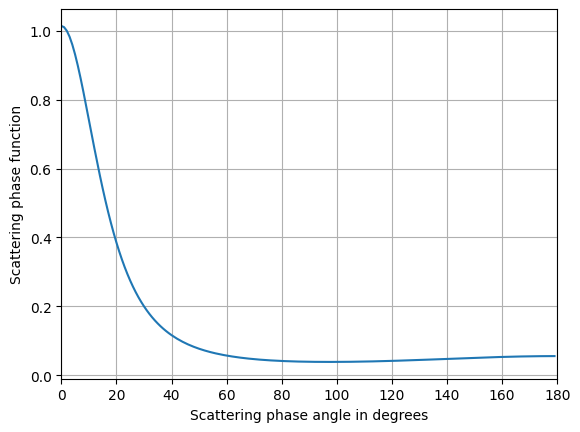

In [7]:
fake_disk1.phase_function.plot_phase_function()

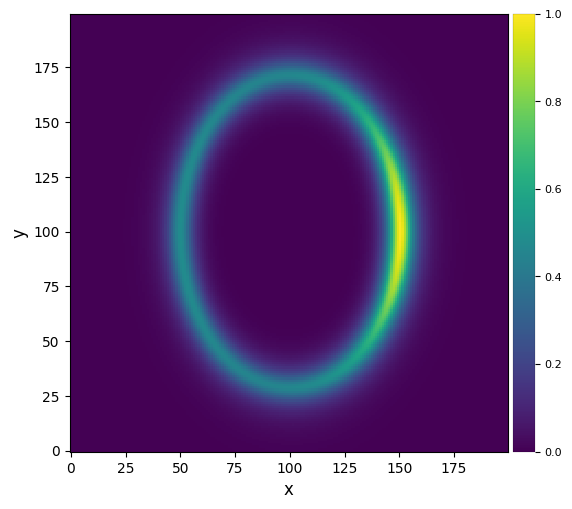

In [8]:
fake_disk1_map = fake_disk1.compute_scattered_light()
plot_frames(fake_disk1_map, grid=False, size_factor=6)

In [9]:
fake_disk1.print_info()

-----------------------------------
Geometrical properties of the image
-----------------------------------
Image size: 200 px by 200 px
Pixel size: 0.0123 arcsec/px or 0.98 au/px
Distance of the star 80.0 pc
From -98.0 au to 97.0 au in X
From -98.0 au to 97.0 au in Y
Position angle of the disc: 0.00 degrees
Inclination 45.00 degrees
Argument of pericenter 0.00 degrees
Maximum flux of the disk 1.00
----------------------------
Dust distribution parameters
----------------------------
Reference semi-major axis: 70.0au
Semi-major axis at maximum dust density in plane z=0: 70.0au (same as ref sma if ain=-aout)
Semi-major axis at half max dust density: 64.2au / 76.3au for the inner/outer edge, or a FWHM of 12.1au
Semi-major axis at maximum dust surface density: 70.2au (same as ref sma if ain=-aout)
Ellipse p parameter: 70.0au
Ellipticity: 0.000
Inner slope: 12.00
Outer slope: -12.00
Density at the reference semi-major axis: 1.000e+00 (arbitrary unit
Scale height: 3.00 au at 70.00
Vertical 

## PSF

In [10]:
from astropy.io import fits

filename = "../Sphere_hr4796_PSF_convolution.fits"
fits.info(filename)

Filename: ../Sphere_hr4796_PSF_convolution.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU       6   (31, 31)   float32   


In [11]:
with fits.open(filename) as hdulist: 
    header = hdulist[0].header
    PSF = hdulist[0].data

In [12]:
print(repr(header))

SIMPLE  =                    T / conforms to FITS standard                      
BITPIX  =                  -32 / array data type                                
NAXIS   =                    2 / number of array dimensions                     
NAXIS1  =                   31                                                  
NAXIS2  =                   31                                                  
EXTEND  =                    T                                                  


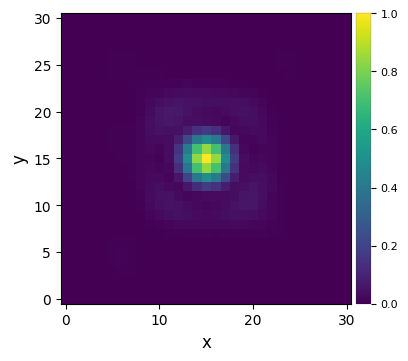

In [13]:
plot_frames(PSF, size_factor=4)

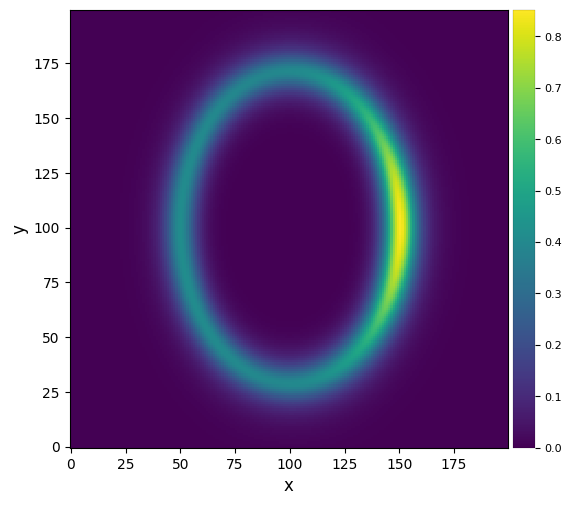

In [14]:
from astropy.convolution import convolve

fake_disk1_conv = convolve(fake_disk1_map,PSF)
plot_frames(fake_disk1_conv, grid=False, size_factor=6)

## Noise

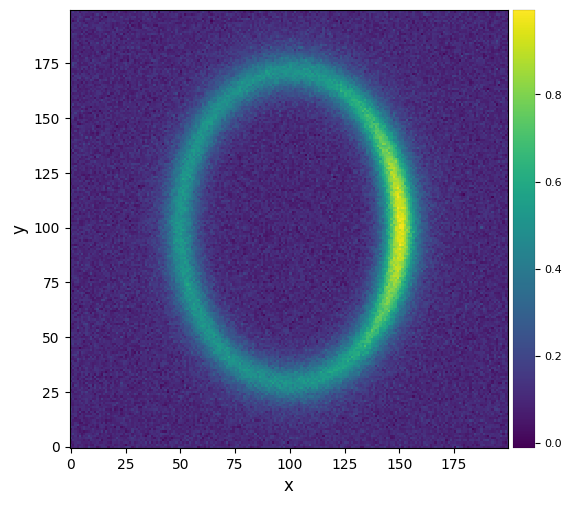

In [48]:
dim1 = fake_disk1_conv.shape[0]
dim2 = fake_disk1_conv.shape[1]

mean = 0 
var = 0.01
sigma = np.sqrt(var)
err = 0.1 + 0.3 * np.random.normal(loc=mean,scale=sigma,size=(dim1,dim2))
fake_disk1_conv_noise = fake_disk1_conv + err

plot_frames(fake_disk1_conv_noise, grid=False, size_factor=6)

## MCMC

In [49]:
def log_likelihood(theta, data, zerr):
    itilt, a, ksi0, alpha_in, alpha_out, g1, g2, weight1 = theta
    
    pixel_scale=0.01225 # pixel scale in arcsec/px
    dstar= 80 # distance to the star in pc
    nx = 200 # number of pixels of your image in X
    ny = 200 # number of pixels of your image in Y
    gamma = 2.
    beta = 1
    
    a = np.abs(a)
    ksi0 = np.abs(ksi0)
    weight1 = np.abs(weight1)

    fake_disk = ScatteredLightDisk(nx=nx, ny=ny, distance=dstar,
                                itilt=itilt, omega=0, pxInArcsec=pixel_scale, pa=0,
                                density_dico={'name':'2PowerLaws','ain':alpha_in,'aout':alpha_out,
                                              'a':a,'e':0.0,'ksi0':ksi0,'gamma':gamma,'beta':beta},
                                spf_dico={'name':'DoubleHG', 'g':[g1,g2], 'weight':weight1, 'polar':False},
                                flux_max=1.)
    model_map = fake_disk.compute_scattered_light()
    # convolve here too
    sigma2 = zerr**2
    
    return -0.5 * np.sum((data - model_map) ** 2 / sigma2 )

In [50]:
from scipy.optimize import minimize

np.random.seed(42)
nll = lambda *args: -log_likelihood(*args)
initial = np.array([itilt, a, ksi0, alpha_in, alpha_out, g1, g2, weight1]) + 0.1 * np.random.randn(8)
soln = minimize(nll, initial, args=(fake_disk1_conv_noise, err))
itilt_ml, a_ml, ksi0_ml, alpha_in_ml, alpha_out_ml, g1_ml, g2_ml, weight1_ml = soln.x

print("Maximum likelihood estimates:")
print("Inclination = {0:.3f}".format(itilt_ml))
print("Semimajor axis = {0:.3f}".format(np.abs(a_ml)))
print("Reference scale height = {0:.3f}".format(np.abs(ksi0_ml)))
print("alpha_in = {0:.3f}".format(alpha_in_ml))
print("alpha_out = {0:.3f}".format(alpha_out_ml))
print("g1 = {0:.3f}".format(g1_ml))
print("g2 = {0:.3f}".format(g2_ml))
print("Weight = {0:.3f}".format(np.abs(weight1_ml)))

Maximum likelihood estimates:
Inclination = 45.311
Semimajor axis = 68.970
Reference scale height = 0.003
alpha_in = 10.536
alpha_out = -8.285
g1 = 0.946
g2 = -0.107
Weight = 0.898


In [51]:
def log_likelihood1(theta, data, zerr):
    itilt, a, ksi0, alpha_in, alpha_out, g1, g2, weight1 = theta
    
    pixel_scale=0.01225 # pixel scale in arcsec/px
    dstar= 80 # distance to the star in pc
    nx = 200 # number of pixels of your image in X
    ny = 200 # number of pixels of your image in Y
    gamma = 2.
    beta = 1

    fake_disk = ScatteredLightDisk(nx=nx, ny=ny, distance=dstar,
                                itilt=itilt, omega=0, pxInArcsec=pixel_scale, pa=0,
                                density_dico={'name':'2PowerLaws','ain':alpha_in,'aout':alpha_out,
                                              'a':a,'e':0.0,'ksi0':ksi0,'gamma':gamma,'beta':beta},
                                spf_dico={'name':'DoubleHG', 'g':[g1,g2], 'weight':weight1, 'polar':False},
                                flux_max=1.)
    model_map = fake_disk.compute_scattered_light()
    # convolve here too
    sigma2 = zerr**2
    
    return -0.5 * np.sum((data - model_map) ** 2 / sigma2 )

In [52]:
%%time

def log_prior(theta):
    itilt, a, ksi0, alpha_in, alpha_out, g1, g2, weight1 = theta
    if 0 < itilt < 90.0 and 0.0 < a < 100.0 and 0.0 < ksi0 < 100.0 and -20.0 < alpha_in < 20.0 and -20.0 < alpha_out < 20.0 and 0.0 < g1 < 1.0 and -1.0 < g2 < 0.0 and 0.0 < weight1 < 1.0:
        return 0.0
    return -np.inf

def log_probability(theta, data, zerr):
    lp = log_prior(theta)
    if not np.isfinite(lp):
        return -np.inf
    return lp + log_likelihood1(theta, data, zerr)

import emcee

pos = soln.x + 1e-4 * np.random.randn(32, 8)
pos[:,2] = np.abs(pos[:,2])
nwalkers, ndim = pos.shape

sampler = emcee.EnsembleSampler(
    nwalkers, ndim, log_probability, args=(fake_disk1_conv_noise, err)
)
sampler.run_mcmc(pos, 5000, progress=True);

100%|█████████████████████████████████████| 5000/5000 [9:51:48<00:00,  7.10s/it]

CPU times: user 8h 36min 22s, sys: 1.7 s, total: 8h 36min 24s
Wall time: 9h 51min 55s


State([[ 4.55792887e+01  6.88373237e+01  4.82070846e-02  1.06450842e+01
  -7.87188582e+00  9.13541456e-01 -9.04940832e-02  8.39154746e-01]
 [ 4.55127665e+01  6.87648983e+01  1.84915937e-01  1.06933843e+01
  -7.85250805e+00  8.97440374e-01 -8.91601740e-02  8.13515832e-01]
 [ 4.55725985e+01  6.88143406e+01  4.12421445e-02  1.06649511e+01
  -7.85593301e+00  9.64348521e-01 -8.58944671e-02  9.28171028e-01]
 [ 4.55101190e+01  6.87312967e+01  8.19742245e-02  1.07431446e+01
  -7.83969646e+00  9.70376830e-01 -8.41201579e-02  9.39429404e-01]
 [ 4.55891671e+01  6.88356107e+01  3.61703556e-02  1.06986072e+01
  -7.85608514e+00  8.89871321e-01 -9.31515678e-02  8.03314126e-01]
 [ 4.55758115e+01  6.88178222e+01  1.79911773e-01  1.06949774e+01
  -7.85278442e+00  9.48073155e-01 -8.90516414e-02  8.98175200e-01]
 [ 4.56128607e+01  6.88641493e+01  1.15155998e-03  1.06811735e+01
  -7.84306018e+00  9.72622919e-01 -8.74242190e-02  9.44324418e-01]
 [ 4.55762061e+01  6.87982810e+01  1.48833958e-01  1.07467340e+

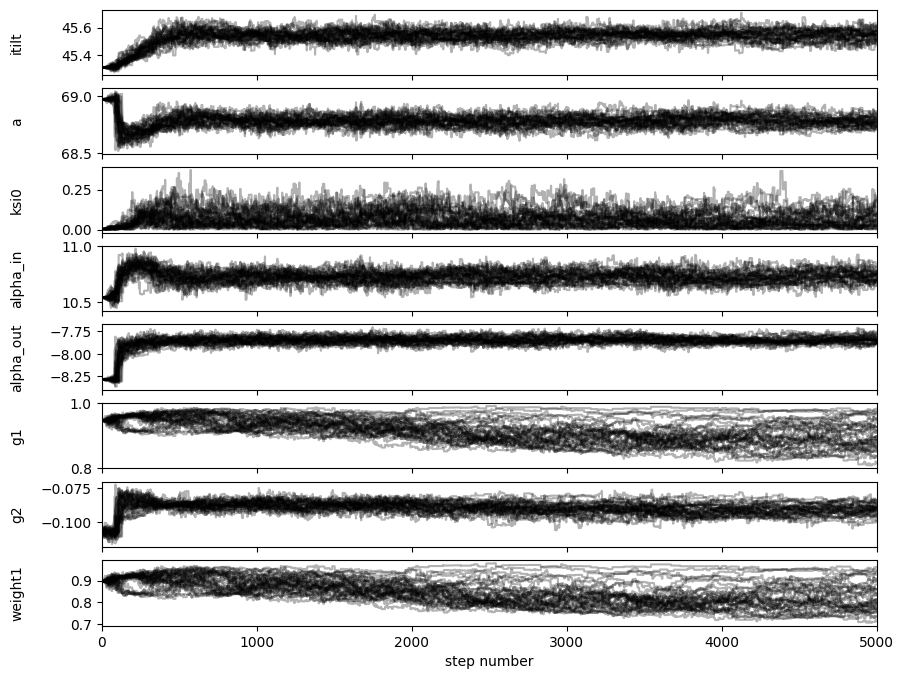

In [53]:
fig, axes = plt.subplots(8, figsize=(10, 8), sharex=True)
samples = sampler.get_chain()
labels = ["itilt", "a", "ksi0", "alpha_in", "alpha_out", "g1", "g2", "weight1"]
for i in range(ndim):
    ax = axes[i]
    ax.plot(samples[:, :, i], "k", alpha=0.3)
    ax.set_xlim(0, len(samples))
    ax.set_ylabel(labels[i])
    ax.yaxis.set_label_coords(-0.1, 0.5)

axes[-1].set_xlabel("step number");

In [54]:
flat_samples = sampler.get_chain(discard=200, thin=15, flat=True)
print(flat_samples.shape)

(10240, 8)


In [55]:
from IPython.display import display, Math

labels = ["itilt", "a", "ksi0", "alpha_{in}", "alpha_{out}", "g_1", "g_2", "weight1"]

for i in range(ndim):
    mcmc = np.percentile(flat_samples[:, i], [16, 50, 84])
    q = np.diff(mcmc)
    txt = "\mathrm{{{3}}} = {0:.3f}_{{-{1:.3f}}}^{{{2:.3f}}}"
    txt = txt.format(mcmc[1], q[0], q[1], labels[i])
    display(Math(txt))

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

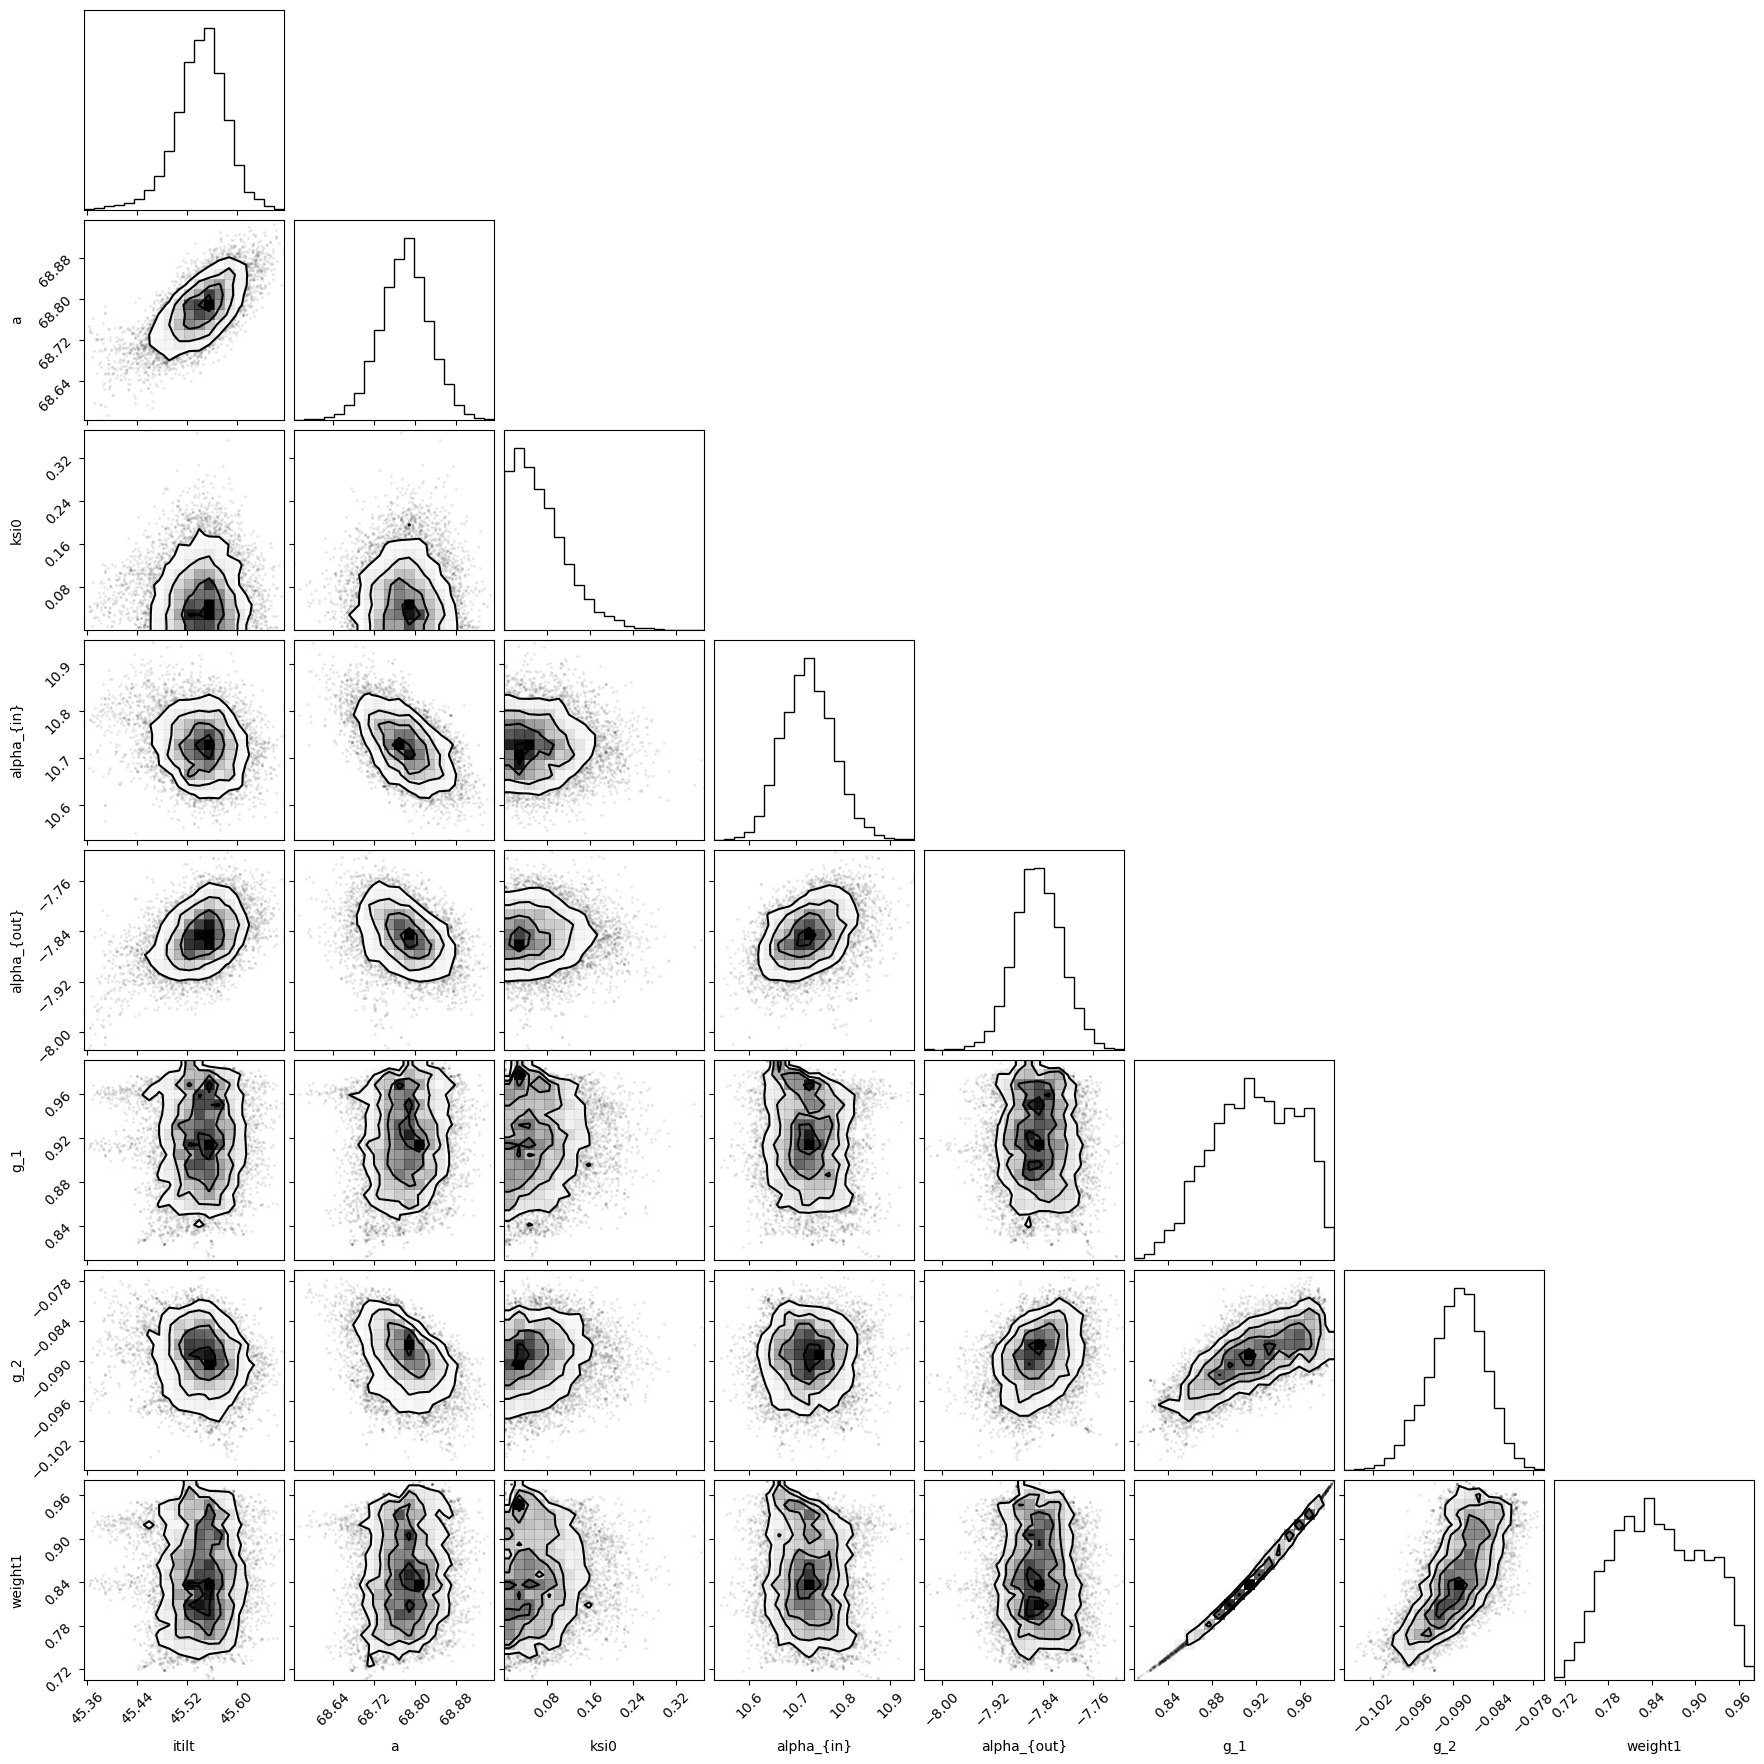

In [56]:
import corner

fig = corner.corner(
    flat_samples, labels=labels, truths=[itilt,a,ksi0,alpha_in,alpha_out,g1,g2,weight1]
);